### Imports

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import f1_score
import recordlinkage as rl
from numpy.random import choice
from sklearn.utils import shuffle
import collections

# Models to use
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt

### Only run once to download to drive initially

In [56]:
#nltk.download('punkt')

### Load the patient record dataset

In [57]:
#filename = 'test5'
#filename = 'febrl4_UNSW'
#filename = 'ePBRN_F_dup'
filename = 'febrl3_UNSW_rep'
data = pd.read_csv(f"../test/{filename}.csv")
random_seed = 42

In [58]:
# Test that this makes a copy of the data
# test1 = data
# test2 = data

# test1 = pd.concat([test1, test1.loc[[0]]], ignore_index=True)

# print(len(test1))
# print(len(test2))
# # print(test1.iloc[0]['rec_id'])
# # print(test2.iloc[0]['rec_id'])

### Clean up record IDs

In [59]:
# Cleanup records
data['rec_id'] = data['rec_id'].str.replace("rec-", "")
data['rec_id'] = data['rec_id'].str.replace("-org", "")

### Handle Missing Values and Clean Up

In [60]:
# Combine 'street_number', 'address_1', and 'address_2' into one field and clean it
#data['address'] = data['street_number'].astype(str) + ' ' + data['address_1'].astype(str) + ' ' + data['address_2'].astype(str)
#data['address'] = data['address'].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x))

if ('date_of_birth' in data):
    data['date_of_birth']  = pd.to_datetime(data['date_of_birth'], errors = 'coerce')
    data['day'] = data['date_of_birth'].dt.strftime('%d')
    data['month'] = data['date_of_birth'].dt.strftime('%m')
    data['year'] = data['date_of_birth'].dt.strftime('%Y')

## New
# Fill missing values for 'culture', 'sex', and 'state' with a default value
default_values = {'sex': 'unknown', 'state': 'unknown'}
data.fillna(value=default_values, inplace=True)

# Remove extra spaces from string columns
string_columns = ['given_name', 'surname', 'address_1', 'address_2']
for col in string_columns:
    data[col] = data[col].astype(str).str.strip().str.lower()

# Impute missing values for numerical columns with the mean value
if ('date_of_birth' in data):
    numerical_columns = ['date_of_birth', 'phone_number', 'national_identifier', 'blocking_number']
else:
    numerical_columns = ['postcode', 'street_number']
for col in numerical_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Drop the 'blocking_number' field
if ('date_of_birth' in data):
    data = data.drop(columns=['culture', 'date_of_birth', 'state'])
#data = data.drop(columns=['blocking_number', 'street_number', 'address_1', 'address_2', 'date_of_birth', 'culture', 'state'])

if ('sex' in data):
    for col in ["surname", "given_name", "address_1", "address_2", "sex"]:
        data[col] = data[col].fillna('unknown')
        data[col] = data[col].astype(str)
else:
    for col in ["surname", "given_name", "address_1", "address_2"]:
        data[col] = data[col].fillna('unknown')
        data[col] = data[col].astype(str)

### Deal with Duplicates

In [61]:
if "match_id" not in data:
    # Identify known duplicates based on the rec_id column
    duplicates = data[data["rec_id"].str.contains("-dup-")]

    # Create a dictionary mapping each duplicate record to its corresponding original record
    originals = {}
    for i, row in duplicates.iterrows():
        original_id = row["rec_id"].replace("-dup-0", "")
        if original_id in originals:
            originals[original_id].append(i)
        else:
            originals[original_id] = [i]

    # Create a new column called "match" to indicate whether a record is a duplicate or not
    data["match_id"] = data["rec_id"]
    for original_id, duplicates in originals.items():
        data.loc[duplicates, "match_id"] = original_id
        # this ensures that both the duplicate and the match are in the same training set
        data.loc[data['rec_id'] == original_id, 'match_id'] = original_id

    data["match_id"] = data["match_id"].astype(int)

# get all fields
all_fields = data.columns.values.tolist()
print("All fields:", all_fields)

All fields: ['Unnamed: 0', 'rec_id', 'given_name', 'surname', 'street_number', 'address_1', 'address_2', 'suburb', 'postcode', 'state', 'day', 'month', 'year', 'match_id']


In [62]:
# Test true links
def generate_true_links(df): 
    # although the match_id column is included in the original df to imply the true links,
    # this function will create the true_link object identical to the true_links properties
    # of recordlinkage toolkit, in order to exploit "Compare.compute()" from that toolkit
    # in extract_function() for extracting features quicker.
    # This process should be deprecated in the future release of the UNSW toolkit.
    df["rec_id"] = df.index.values.tolist()
    indices_1 = []
    indices_2 = []
    processed = 0
    for match_id in df["match_id"].unique():
        if match_id != -1:    
            processed = processed + 1
            # print("In routine generate_true_links(), count =", processed)
            # clear_output(wait=True)
            linkages = df.loc[df['match_id'] == match_id]
            for j in range(len(linkages)-1):
                for k in range(j+1, len(linkages)):
                    indices_1 = indices_1 + [linkages.iloc[j]["rec_id"]]
                    indices_2 = indices_2 + [linkages.iloc[k]["rec_id"]]    
    links = pd.MultiIndex.from_arrays([indices_1,indices_2])
    return links

def generate_false_links(df, size):
    # A counterpart of generate_true_links(), with the purpose to generate random false pairs
    # for training. The number of false pairs in specified as "size".
    df["rec_id"] = df.index.values.tolist()
    indices_1 = []
    indices_2 = []
    unique_match_id = df["match_id"].unique()
    unique_match_id = unique_match_id[~np.isnan(unique_match_id)] # remove nan values
    for j in range(size):
            false_pair_ids = choice(unique_match_id, 2)
            candidate_1_cluster = df.loc[df['match_id'] == false_pair_ids[0]]
            candidate_1 = candidate_1_cluster.iloc[choice(range(len(candidate_1_cluster)))]
            candidate_2_cluster = df.loc[df['match_id'] == false_pair_ids[1]]
            candidate_2 = candidate_2_cluster.iloc[choice(range(len(candidate_2_cluster)))]    
            indices_1 = indices_1 + [candidate_1["rec_id"]]
            indices_2 = indices_2 + [candidate_2["rec_id"]]  
    links = pd.MultiIndex.from_arrays([indices_1,indices_2])
    return links

def swap_fields_flag(f11, f12, f21, f22):
    return ((f11 == f22) & (f12 == f21)).astype(float)

def join_names_space(f11, f12, f21, f22):
    return ((f11+" "+f12 == f21) | (f11+" "+f12 == f22)| (f21+" "+f22 == f11)| (f21+" "+f22 == f12)).astype(float)

def join_names_dash(f11, f12, f21, f22):
    return ((f11+"-"+f12 == f21) | (f11+"-"+f12 == f22)| (f21+"-"+f22 == f11)| (f21+"-"+f22 == f12)).astype(float)

def abb_surname(f1, f2):
    return ((f1[0]==f2) | (f1==f2[0])).astype(float)

def reset_day(f11, f12, f21, f22):
    return (((f11 == 1) & (f12 == 1))|((f21 == 1) & (f22 == 1))).astype(float)

def extract_features(df, links):
    c = rl.Compare()
    c.string('given_name', 'given_name', method='jarowinkler', label='y_name_jaro', threshold=0.90)
    c.string('surname', 'surname', method='jarowinkler', label='y_surname_jaro', threshold=0.90)  
    if ('postcode' in data):
        exact_fields = ['street_number', 'year', 'postcode', 'day', 'month', 'address_1', 'address_2']
    else:
        exact_fields = ['street_number', 'year', 'day', 'month', 'address_1', 'address_2']
    for field in exact_fields:
        c.exact(field, field, label='y_'+field+'_exact')
    c.string('address_1', 'address_1', method='levenshtein', label='y_address_1_leven', threshold=0.75)
    c.string('address_2', 'address_2', method='levenshtein', label='y_address_2_leven', threshold=0.75)

    if ('national_identifier' in data):
        data['national_identifier'] = data['national_identifier'].astype(str)
    if ('phone_number' in data):
        data['phone_number'] = data['phone_number'].astype(str)
    if ('national_identifier' in data):
        c.string('national_identifier', 'national_identifier', label='y_national_identifier_num', missing_value="-1")
    if ('phone_number' in data):
        c.string('phone_number', 'phone_number', label='y_phone_number_num', missing_value="-1")

    c.compare_vectorized(reset_day,('day', 'month'), ('day', 'month'),label='reset_day_flag')    
    c.compare_vectorized(swap_fields_flag,('day', 'month'), ('day', 'month'),label='swap_day_month')    
    c.compare_vectorized(swap_fields_flag,('surname', 'given_name'), ('surname', 'given_name'),label='swap_names')    
    c.compare_vectorized(join_names_space,('surname', 'given_name'), ('surname', 'given_name'),label='join_names_space')
    c.compare_vectorized(join_names_dash,('surname', 'given_name'), ('surname', 'given_name'),label='join_names_dash')
    # Build features
    feature_vectors = c.compute(links, df, df)
    return feature_vectors

# see example of true links
true_links_data = generate_true_links(data)
#print(true_links_data)

false_links_data = generate_false_links(data, len(true_links_data))
#print(false_links_data)

# get negative and positive features
pos = extract_features(data, true_links_data)
print('Pos\n')
print(pos)

neg = extract_features(data, false_links_data)
print('Neg\n')
print(neg)

Pos

           y_name_jaro  y_surname_jaro  y_street_number_exact  y_year_exact   
1    884           1.0             1.0                      1             1  \
     1433          1.0             1.0                      1             1   
     2465          1.0             1.0                      1             1   
     3762          1.0             1.0                      1             1   
884  1433          1.0             1.0                      1             1   
...                ...             ...                    ...           ...   
4732 4776          1.0             1.0                      1             1   
4783 4928          1.0             1.0                      1             1   
4801 4894          1.0             1.0                      1             1   
4825 4965          1.0             1.0                      1             1   
4918 4983          1.0             1.0                      1             1   

           y_postcode_exact  y_day_exact  y_mo

### Encode data for machine learning

In [63]:
def generate_train_X_y():
    # This routine is to generate the feature vector X and the corresponding labels y
    # with exactly equal number of samples for both classes to train the classifier.
    X = pos.values.tolist() + neg.values.tolist()
    y = [1]*len(pos)+[0]*len(neg)
    X, y = shuffle(X, y, random_state=random_seed)
    X = np.array(X)
    y = np.array(y)
    return X, y

X_train, y_train = generate_train_X_y()

print('X_train\n')
print(len(X_train))

print('y_train\n')
print(len(y_train))

X_train

13076
y_train

13076


### Initialize machine learning models

In [64]:
def train_model(modeltype, modelparam, train_vectors, train_labels, modeltype_2):
    if modeltype == 'rf': # Random Forest
        if modelparam < 1:
            modelparam = 1
        model = RandomForestClassifier(n_estimators=100, random_state=random_seed, criterion=modeltype_2, max_depth=modelparam)
        model.fit(train_vectors, train_labels)
    elif modeltype == 'gbm': # Gradient Boosted Trees
        model = GradientBoostingClassifier(n_estimators=100, random_state=random_seed, loss=modeltype_2, learning_rate=modelparam)
        model.fit(train_vectors, train_labels) 
    elif modeltype == 'sc': # StackingClassifier
        if modelparam < 2:
            modelparam = 2
        if modelparam > 1000:
            modelparam = 1000
        estimators = [
            ('svr', make_pipeline(StandardScaler(),
                                LinearSVC(random_state=random_seed, C=modelparam)))
        ]
        #model = StackingClassifier(estimators=estimators, stack_method=modeltype_2, cv=modelparam, n_jobs=-1)
        model = StackingClassifier(estimators=estimators, cv=modelparam, n_jobs=-1, final_estimator=LogisticRegression(), stack_method=modeltype_2)
        model.fit(train_vectors, train_labels) 
    elif modeltype == 'lr': # Logistic Regression
        model = LogisticRegression(C=modelparam, penalty = modeltype_2,class_weight=None, dual=False, fit_intercept=True, 
                                   intercept_scaling=1, max_iter=5000, multi_class='ovr', 
                                   n_jobs=1, random_state=random_seed)
        model.fit(train_vectors, train_labels)
    elif modeltype == 'nn': # Neural Network
        model = MLPClassifier(solver='lbfgs', alpha=modelparam, hidden_layer_sizes=(256, ), 
                              activation = modeltype_2,random_state=random_seed, batch_size='auto', 
                              learning_rate='constant',  learning_rate_init=0.001, 
                              power_t=0.5, max_iter=30000, shuffle=True, 
                              tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
                              nesterovs_momentum=True, early_stopping=False, 
                              validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
        model.fit(train_vectors, train_labels)
    return model

def classify(model, test_vectors):
    result = model.predict(test_vectors)
    return result

def set_to_zero_if_nan(value):
    if np.isnan(value):
        return 0
    return value

def evaluation(test_labels, result):
    true_pos = np.logical_and(test_labels, result)
    count_true_pos = np.sum(true_pos)
    true_neg = np.logical_and(np.logical_not(test_labels),np.logical_not(result))
    count_true_neg = np.sum(true_neg)
    false_pos = np.logical_and(np.logical_not(test_labels), result)
    count_false_pos = np.sum(false_pos)
    false_neg = np.logical_and(test_labels,np.logical_not(result))
    count_false_neg = np.sum(false_neg)

    precision = set_to_zero_if_nan(count_true_pos/(count_true_pos+count_false_pos))
    sensitivity = set_to_zero_if_nan(count_true_pos/(count_true_pos+count_false_neg)) # sensitivity = recall
    confusion_matrix = [count_true_pos, count_false_pos, count_false_neg, count_true_neg]
    no_links_found = np.count_nonzero(result)
    no_false = set_to_zero_if_nan(count_false_pos + count_false_neg)
    Fscore = set_to_zero_if_nan(2*precision*sensitivity/(precision+sensitivity))

    a = accuracy_score(test_labels, result)
    c = confusion_matrix
    p = precision
    f = Fscore
    r = sensitivity

    # a = accuracy_score(test_labels, result)
    # c = confusion_matrix(test_labels, result)
    # p = precision_score(test_labels, result)
    # f = f1_score(test_labels, result)
    # r = recall_score(test_labels, result)
    
    metrics_result = {
        'confusion_matrix': c,
        'precision': p,
        'F-score': f, 
        'accuracy_score': a,
        'recall_score': r,
        'sensitivity': sensitivity,
        'no_false': no_false,
        'no_links':no_links_found
    }
    return metrics_result

In [65]:
def blocking_performance(candidates, true_links, df):
    count = 0
    for candi in candidates:
        if df.loc[candi[0]]["match_id"]==df.loc[candi[1]]["match_id"]:
            count = count + 1
    return count

# Blocking Criteria: declare non-match of all of the below fields disagree
# Import
print("Import test set...")
df_test = data
test_true_links = generate_true_links(data)
leng_test_true_links = len(test_true_links)
number_of_records = len(df_test)
number_of_duplicates = leng_test_true_links
print("Test set size:", number_of_records, ", number of matched pairs: ", str(leng_test_true_links))

print("BLOCKING PERFORMANCE:")
if ('postcode' in data):
    blocking_fields = ["given_name", "surname", "postcode"]
else:
    blocking_fields = ["given_name", "surname", "phone_number"]
all_candidate_pairs = []
for field in blocking_fields:
    #block_indexer = rl.BlockIndex(on=field)
    block_indexer = rl.Index().block(on=field)
    candidates = block_indexer.index(df_test)
    detects = blocking_performance(candidates, test_true_links, df_test)
    all_candidate_pairs = candidates.union(all_candidate_pairs)
    print("Number of pairs of matched "+ field +": "+str(len(candidates)), ", detected ",
         detects,'/'+ str(leng_test_true_links) + " true matched pairs, missed " + 
          str(leng_test_true_links-detects) )
detects = blocking_performance(all_candidate_pairs, test_true_links, df_test)
print("Number of pairs of at least 1 field matched: " + str(len(all_candidate_pairs)), ", detected ",
     detects,'/'+ str(leng_test_true_links) + " true matched pairs, missed " + 
          str(leng_test_true_links-detects) )

Import test set...
Test set size: 5000 , number of matched pairs:  6538
BLOCKING PERFORMANCE:
Number of pairs of matched given_name: 51865 , detected  3724 /6538 true matched pairs, missed 2814
Number of pairs of matched surname: 40336 , detected  3627 /6538 true matched pairs, missed 2911
Number of pairs of matched postcode: 16115 , detected  4989 /6538 true matched pairs, missed 1549
Number of pairs of at least 1 field matched: 101781 , detected  6114 /6538 true matched pairs, missed 424


In [66]:
def plot_result(datasetId, fold: int, yList, testSize: int, duplicates: int, metric: str, ylabels: list):
    # x axis values
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.set_xscale('log')
    #ax.locator_params(axis='x', nbins=21)
    #ax.locator_params(axis='y', nbins=11)
    
    # naming the x axis
    plt.xlabel('Hyperparameters')
    # naming the y axis
    plt.ylabel(metric)
    
    # giving a title to my graph
    plt.title(f'Dataset {datasetId}: Metric {metric} - (Fold {fold}) Test set size: {testSize}, number of matched pairs: {duplicates}')
    xlabels = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]

    ax.set_xticks(xlabels)
    ax.set_xticklabels(xlabels, rotation=45)
    if metric != 'falselinks':
        ax.set_yticks(ylabels)

    # Adding padding to x and y axis
    x_padding_factor = 1.1
    y_padding = 0.05  # 5% padding on the y-axis

    # ax.set_xlim([min(xlabels), max(xlabels)])
    # ax.set_ylim([min(ylabels), max(ylabels)])

    ax.set_xlim([min(xlabels) / x_padding_factor, max(xlabels) * x_padding_factor])
    if metric != 'falselinks':
        ax.set_ylim([min(ylabels) - y_padding, max(ylabels) + y_padding])
    
    # Function to plot
    for result in yList:
        values = result['result']
        values = [set_to_zero_if_nan(value) for value in values]
        plt.plot(xlabels, values, label=result['model'], scalex=True, scaley=True)

    plt.legend()

    # function to show the plot
    plt.show()

    # Save
    fig.savefig(f'{datasetId}_fold_{fold}_{metric}.png', bbox_inches='tight')

In [67]:
print("Processing test set...")
print("Preprocess...")
#df_test['postcode'] = df_test['postcode'].astype(str)

# Test feature vectors and labels construction
print("Extract feature vectors...")
df_X_test = extract_features(df_test, all_candidate_pairs)
vectors = df_X_test.values.tolist()
labels = [0]*len(vectors)
feature_index = df_X_test.index
for i in range(0, len(feature_index)):
    if df_test.loc[feature_index[i][0]]["match_id"]==df_test.loc[feature_index[i][1]]["match_id"]:
        labels[i] = 1
X_test, y_test = shuffle(vectors, labels, random_state=random_seed)
X_test = np.array(X_test)
y_test = np.array(y_test)
print("Count labels of y_test:",collections.Counter(y_test))
print("Finished building X_test, y_test")

Processing test set...
Preprocess...
Extract feature vectors...
Count labels of y_test: Counter({0: 95667, 1: 6114})
Finished building X_test, y_test


In [68]:
kfold = KFold(n_splits=10, shuffle=True, random_state=random_seed)

# Use models
modeltype = ['nn', 'lr', 'rf', 'gbm', 'sc'] # choose between 'rf', 'gbm', 'lg', 'sc', 'nn'
modeltype_2 = ['relu', 'l2', 'gini', 'log_loss', 'predict']  # 'l2' or 'none' for lg, 'relu' or 'logistic' for nn, 'log_loss', 'deviance', or 'exponential' for gbm, 'gini', 'entropy', or 'log_loss' for rf, "auto", 'predict_proba', 'decision_function', 'predict' for sc
#modelparam_range = [0.001, 2000, 0.005]
modelparam_range = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000] # C for svm, C for lg, alpha for NN

fold = []
foldCount = 1
for train_index, test_index in kfold.split(X_train):
    # X_train, X_test = X[train_index], X[test_index]
    # y_train, y_test = y[train_index], y[test_index]
    X_train_fold = X_train[train_index]
    y_train_fold = y_train[train_index] 
    for i in range(len(modeltype)):
        for modelparam in modelparam_range:
            md = train_model(modeltype[i], modelparam, X_train_fold, y_train_fold, modeltype_2[i])
            final_result = classify(md, X_test)
            final_eval = evaluation(y_test, final_result)
            precision = final_eval['precision']
            sensitivity = final_eval['sensitivity']
            Fscore = final_eval['F-score']
            confusionMatrix  = final_eval['confusion_matrix']
            accuracyScore  = final_eval['accuracy_score']
            recallScore  = final_eval['recall_score']
            noFalse  = final_eval['no_false']
            noLinks  = final_eval['no_links']

            metrics_result = {
                'fold': foldCount,
                'model': modeltype[i],
                'hyperparameter': modelparam,
                'precision': precision,
                'sensitivity': sensitivity,
                'Fscore': Fscore, 
                'accuracyScore': accuracyScore,
                'confusionMatrix': confusionMatrix,
                'recallScore': recallScore,
                'noFalse': noFalse,
                'noLinks': noLinks,
            }
            fold.append(metrics_result)
    foldCount += 1

## Save Results and Plot

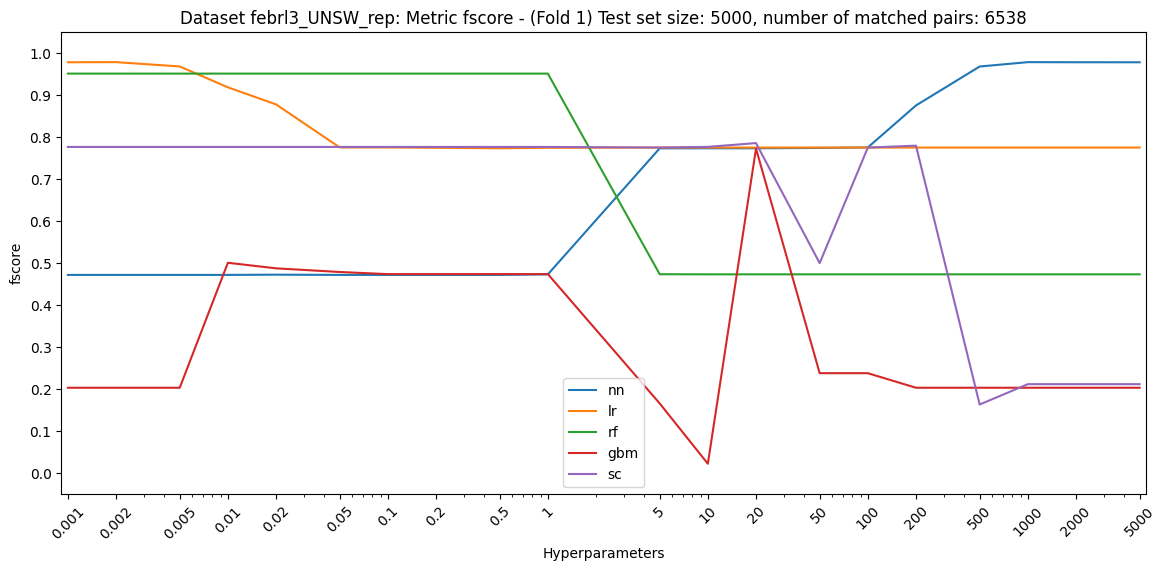

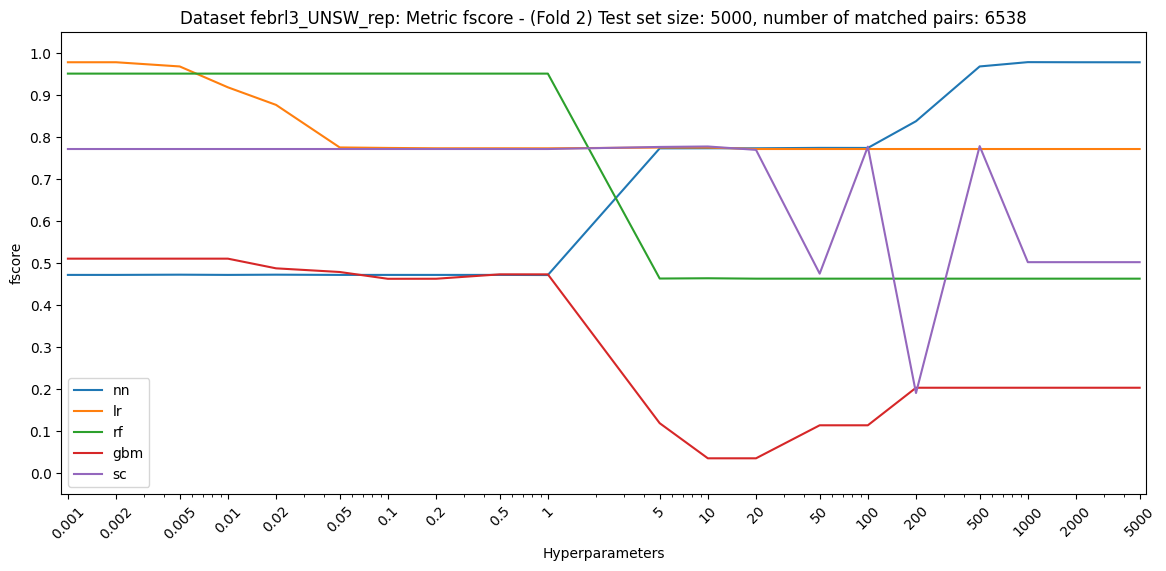

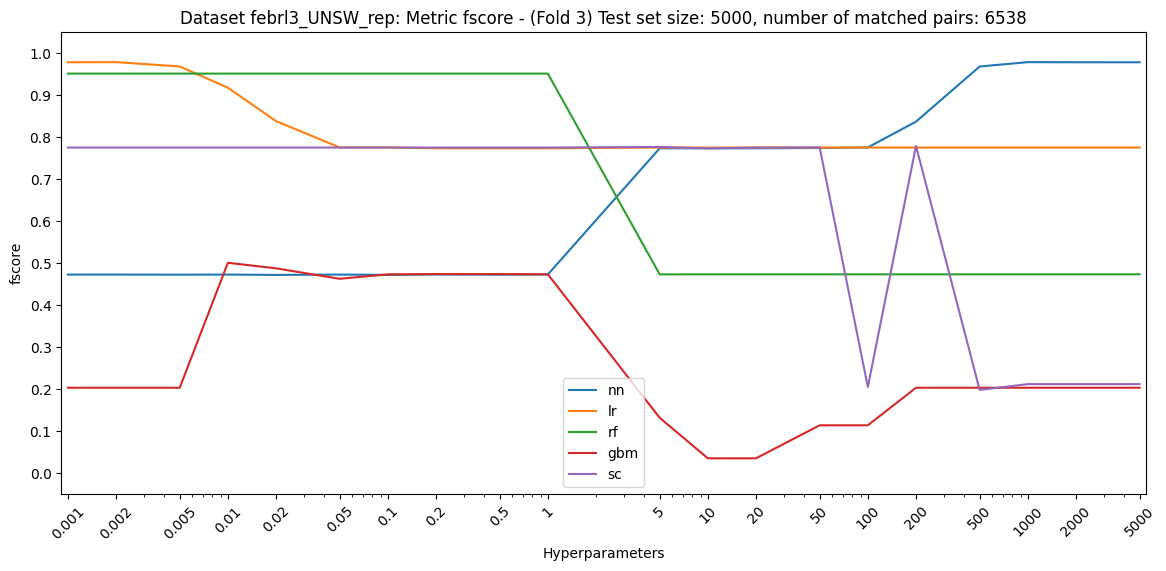

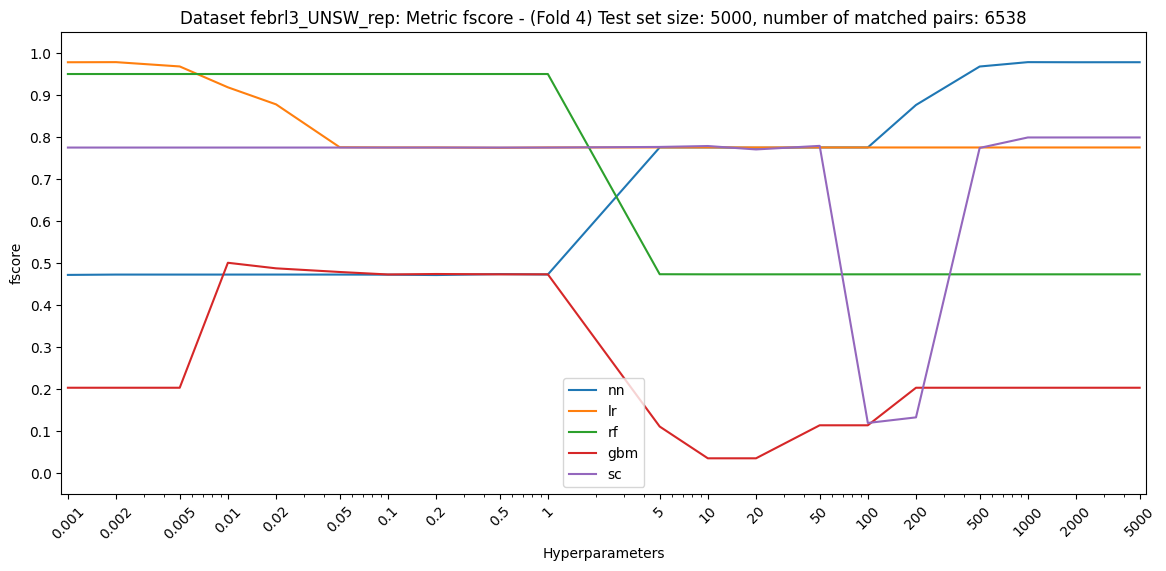

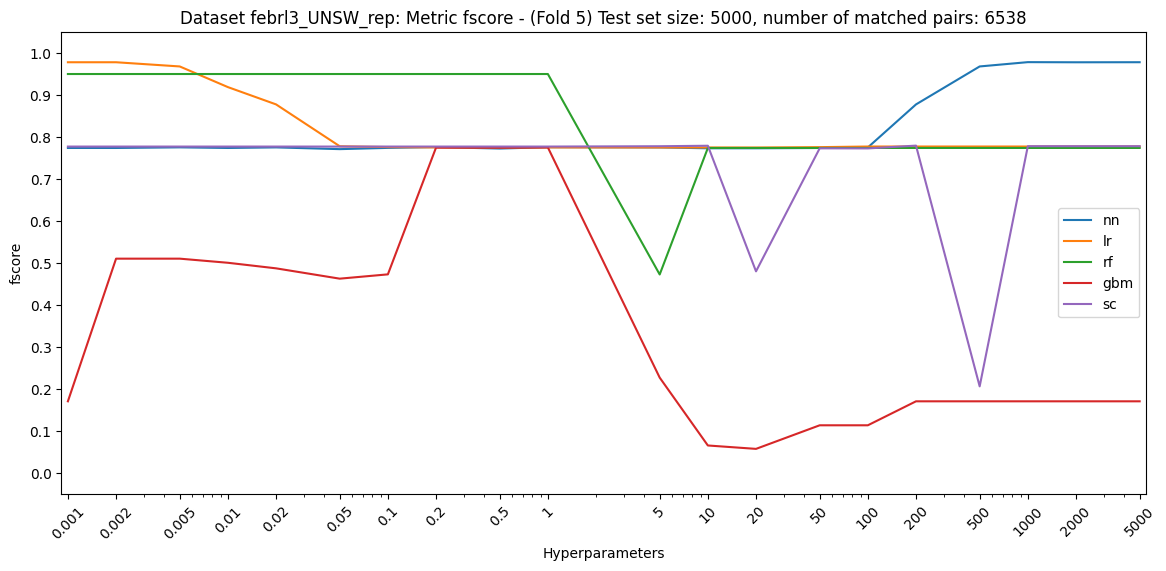

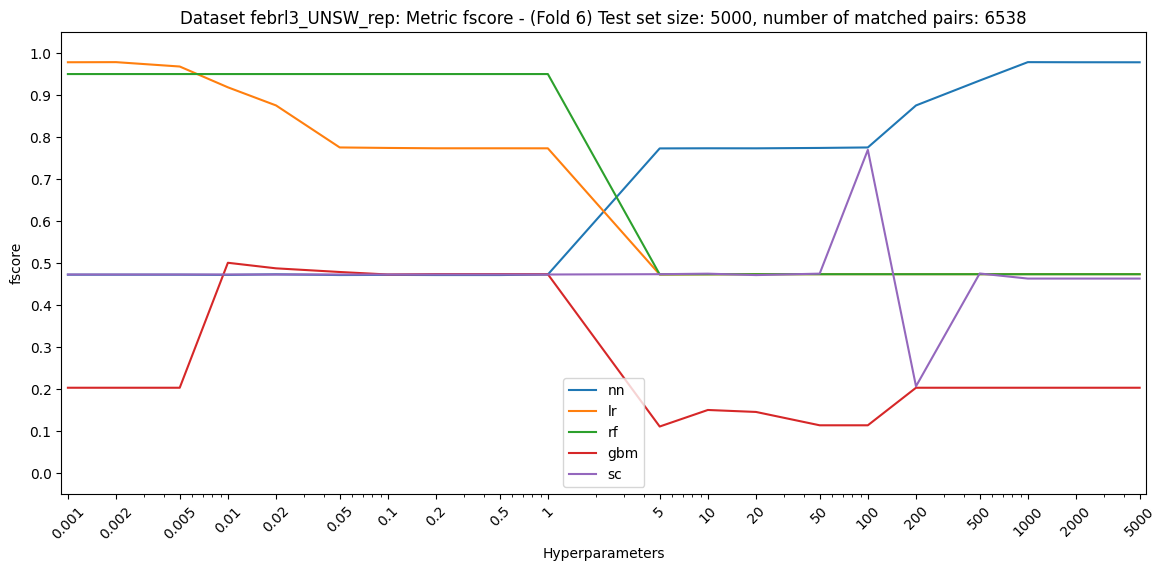

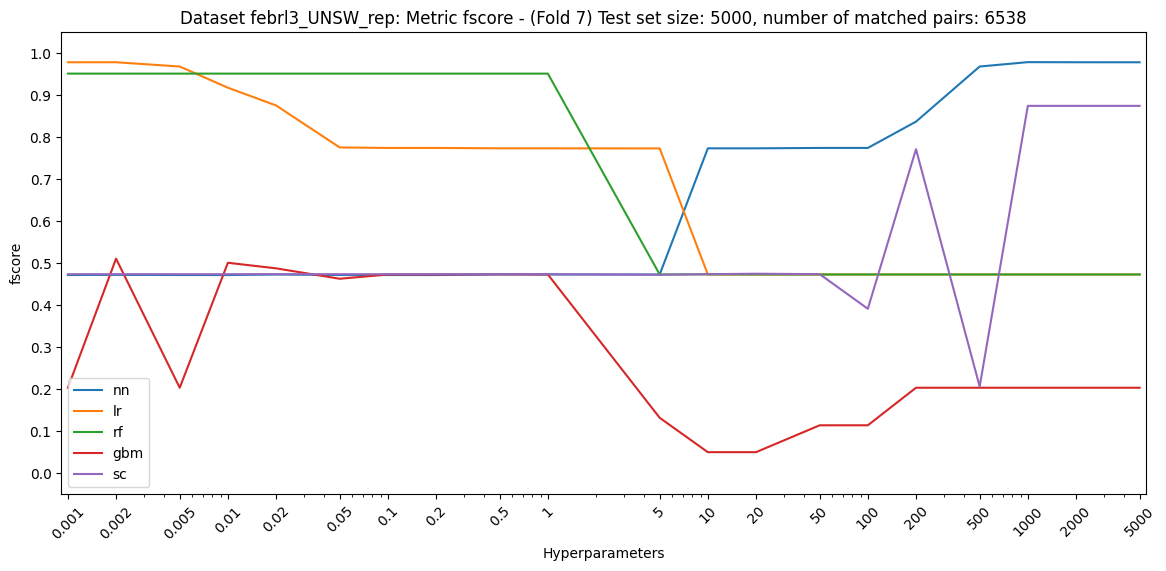

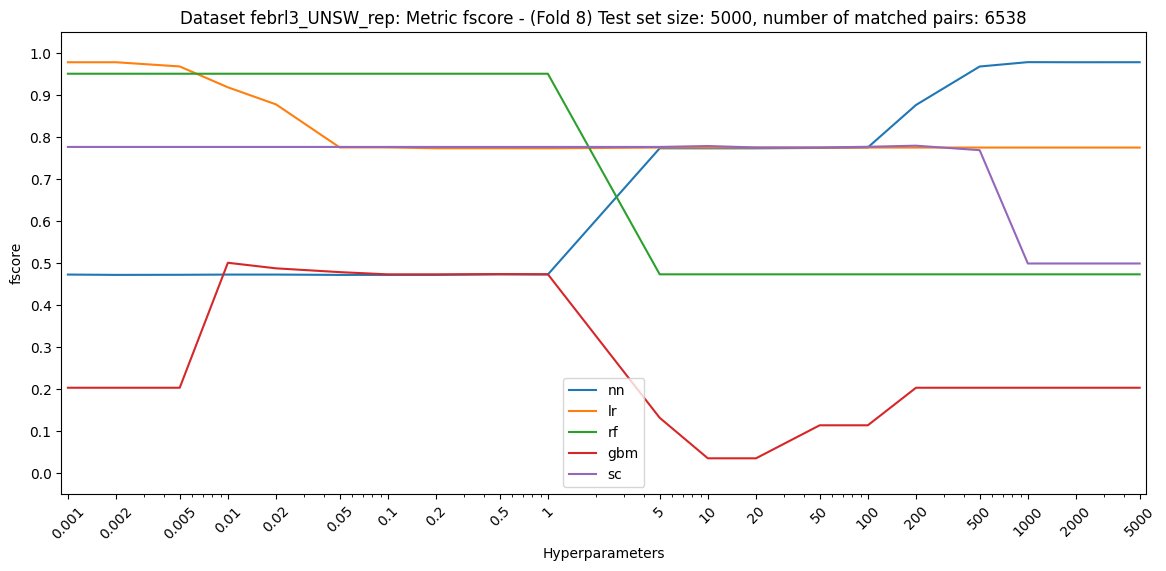

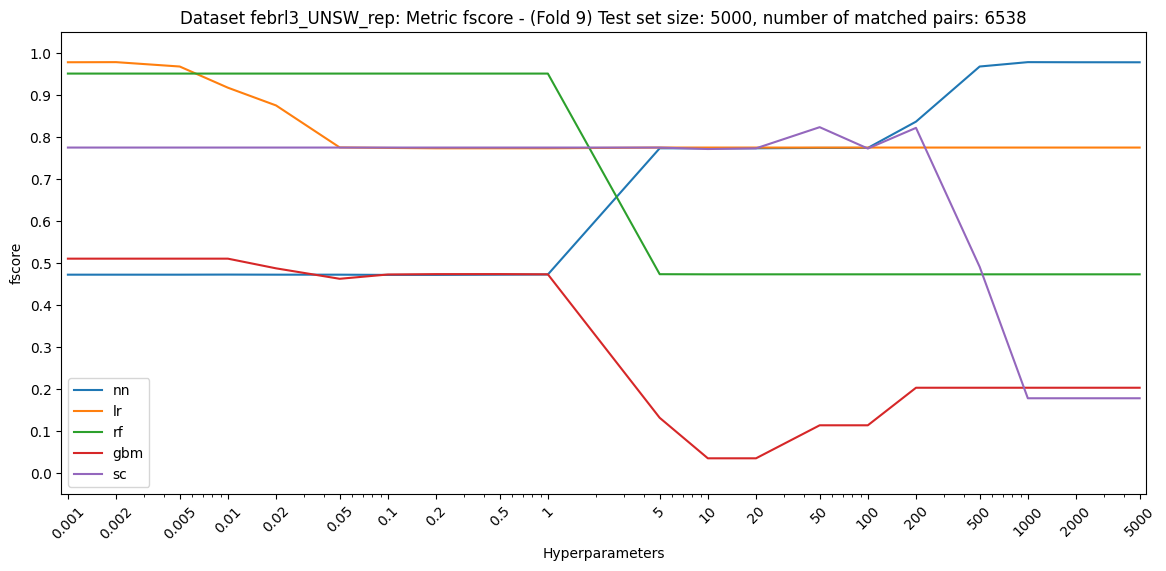

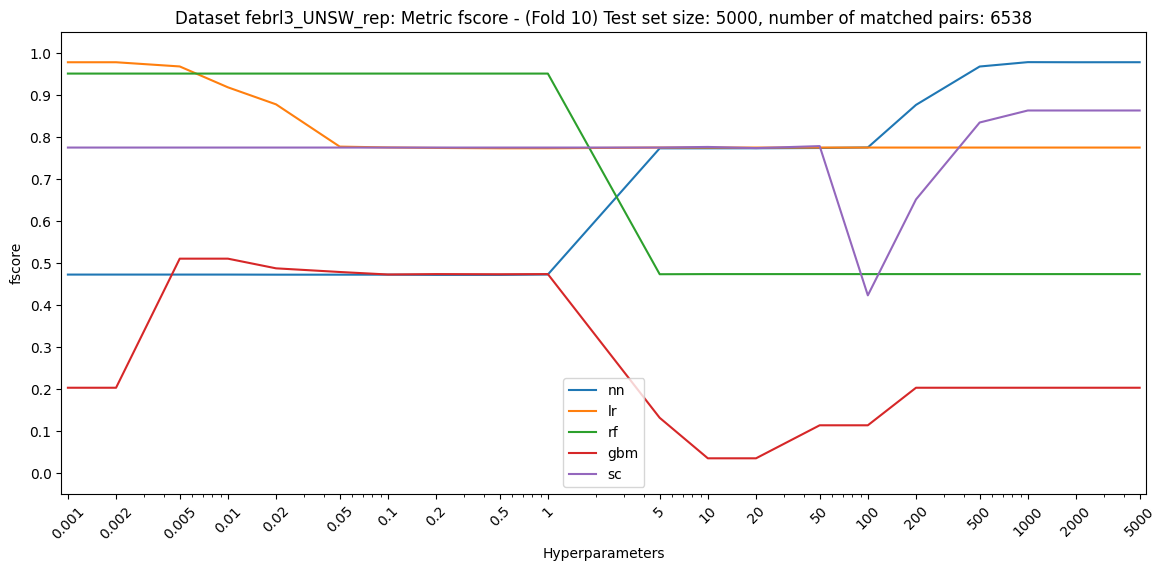

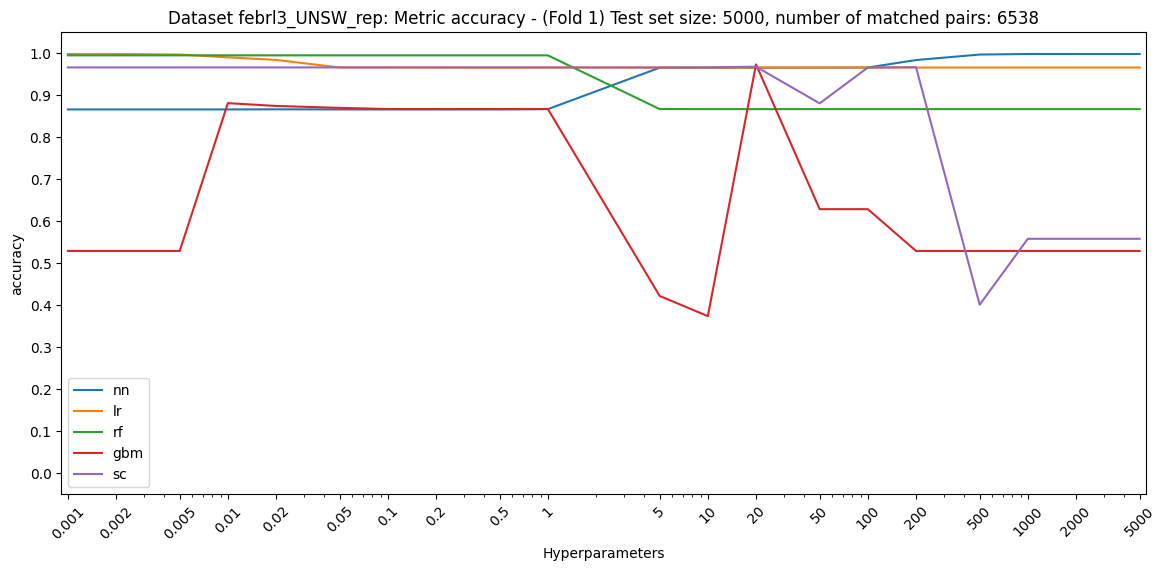

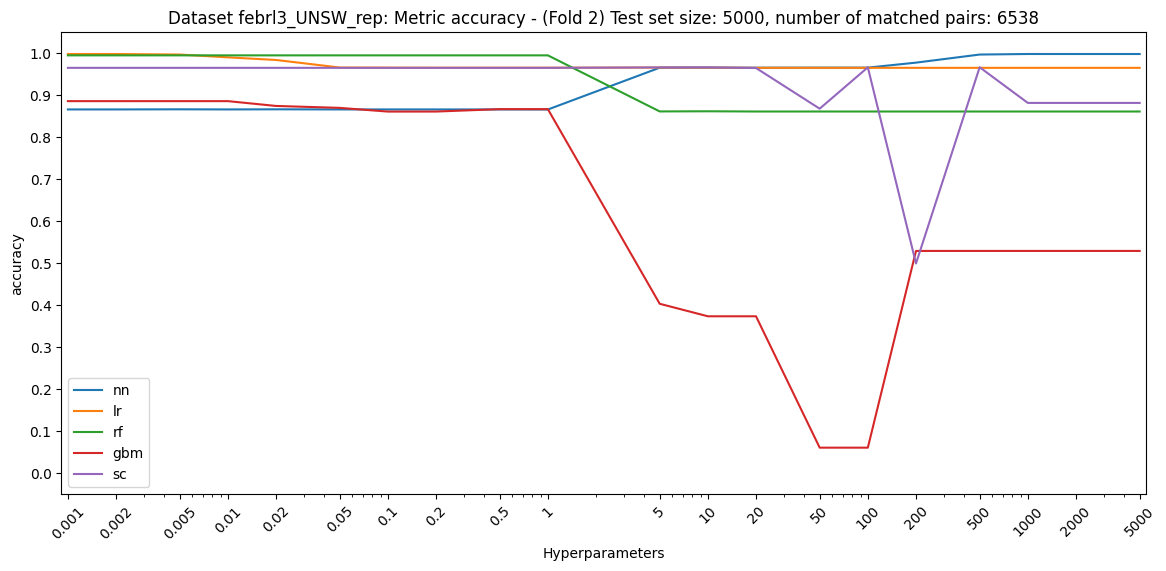

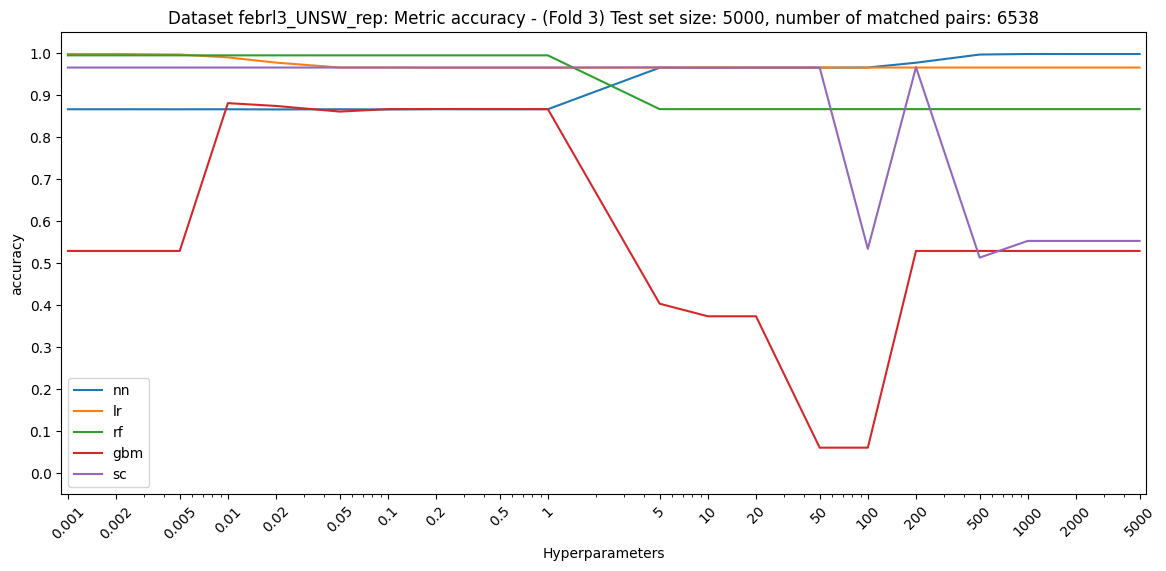

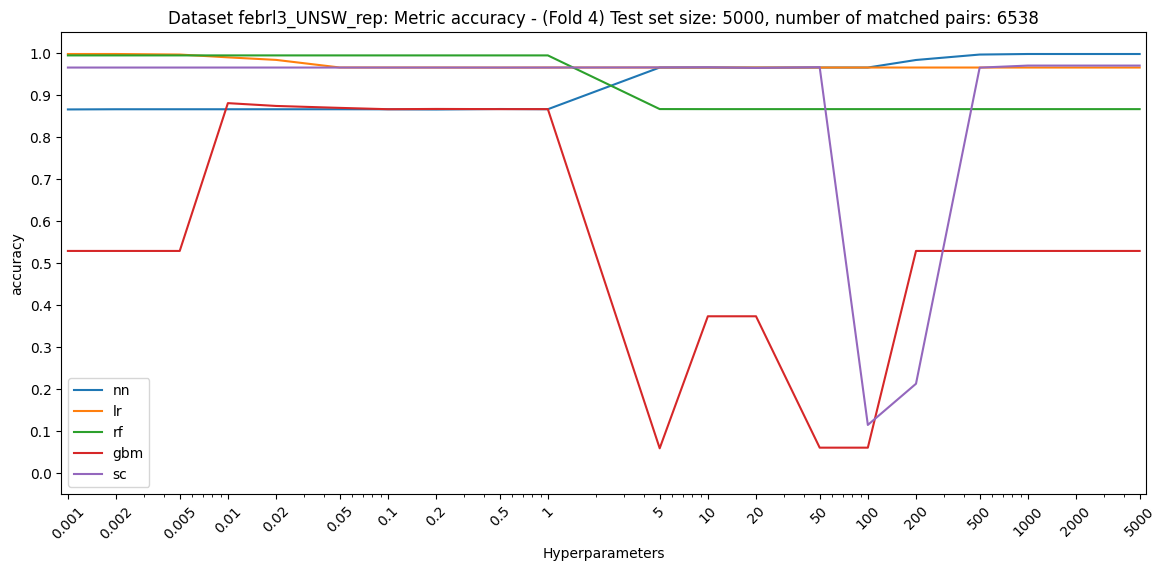

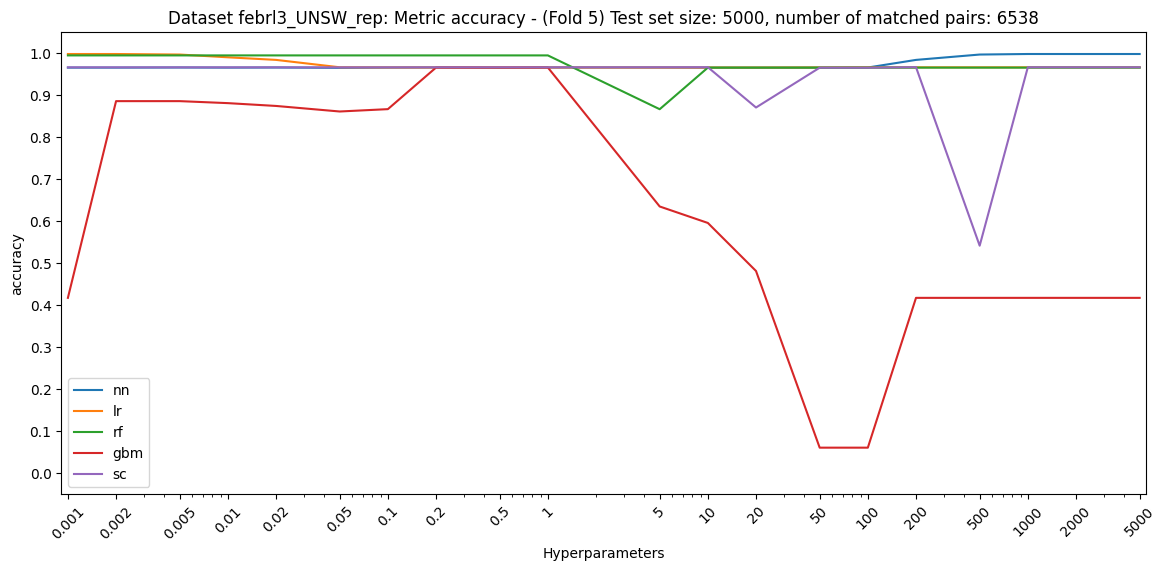

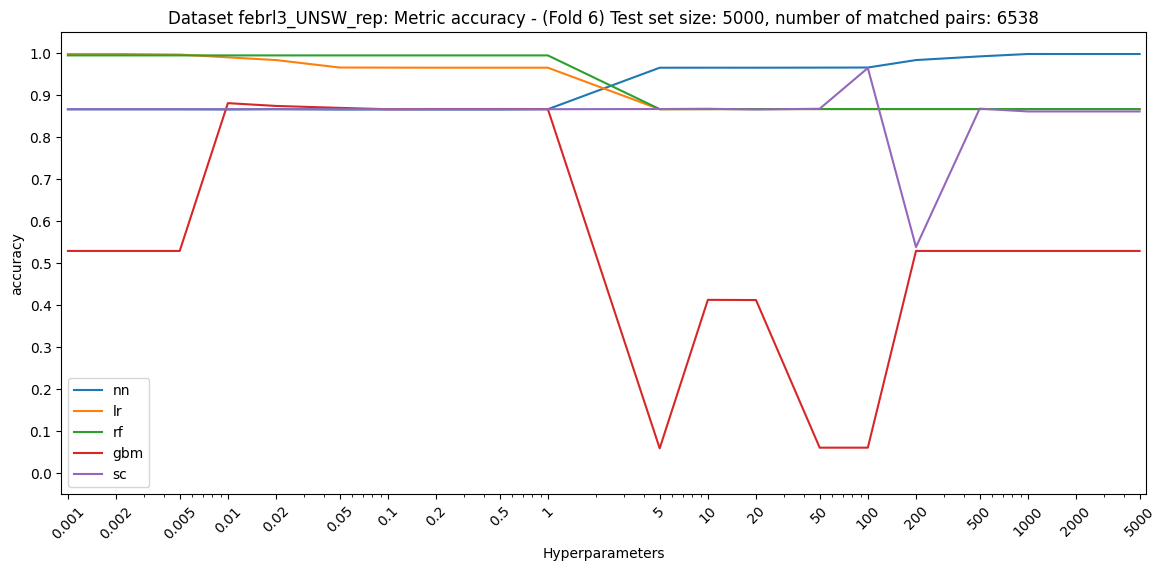

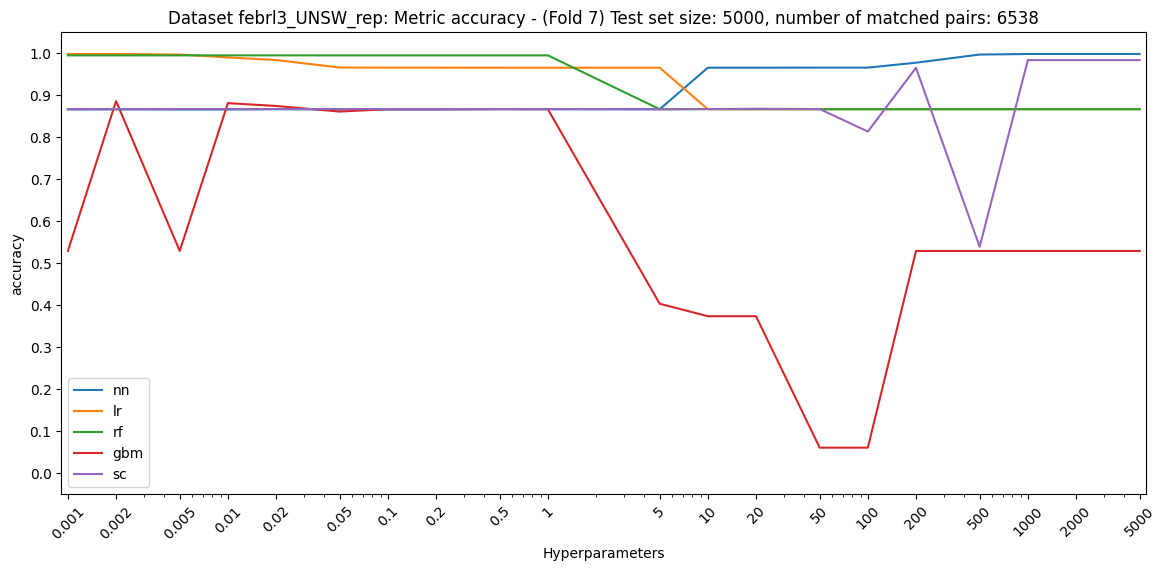

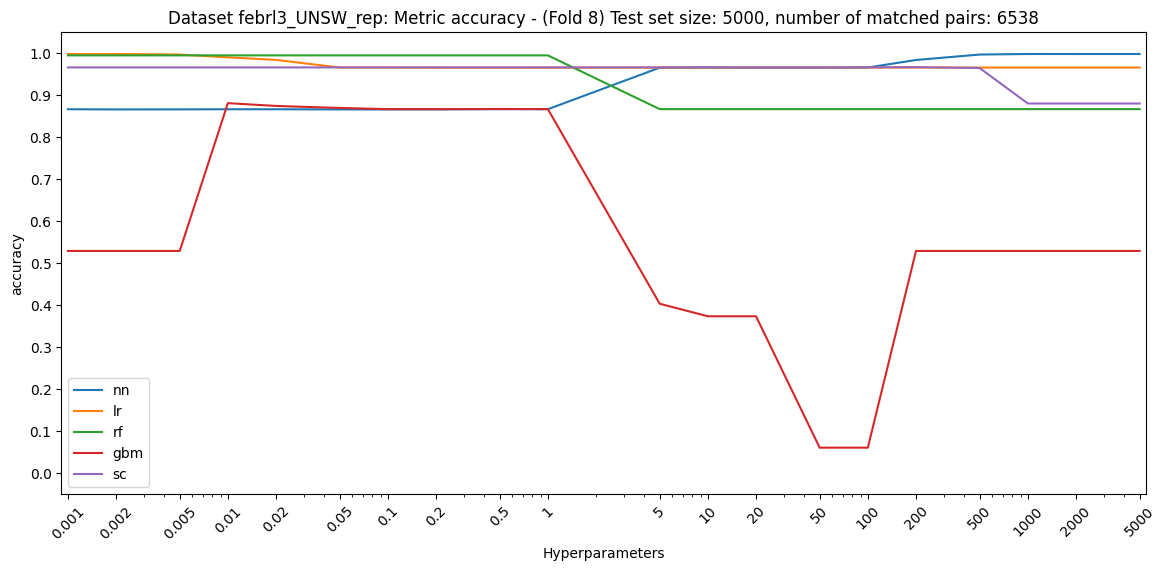

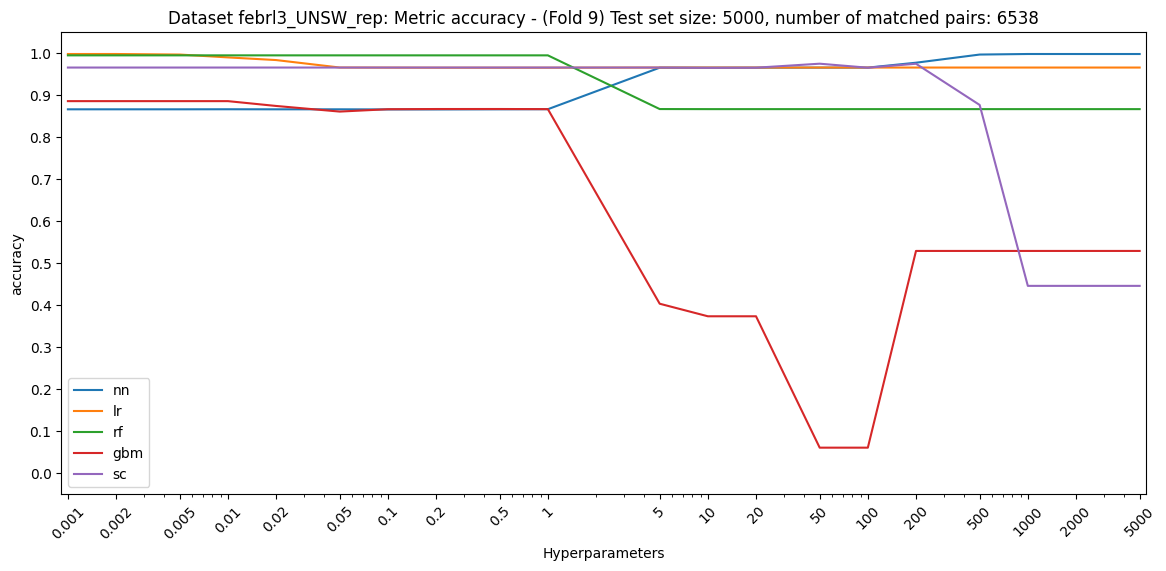

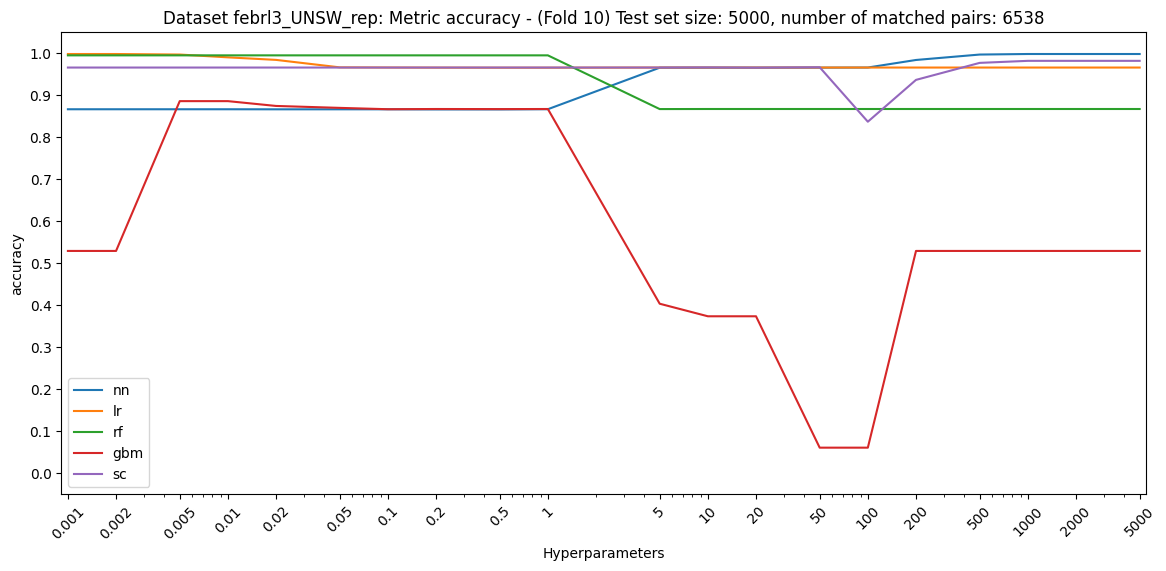

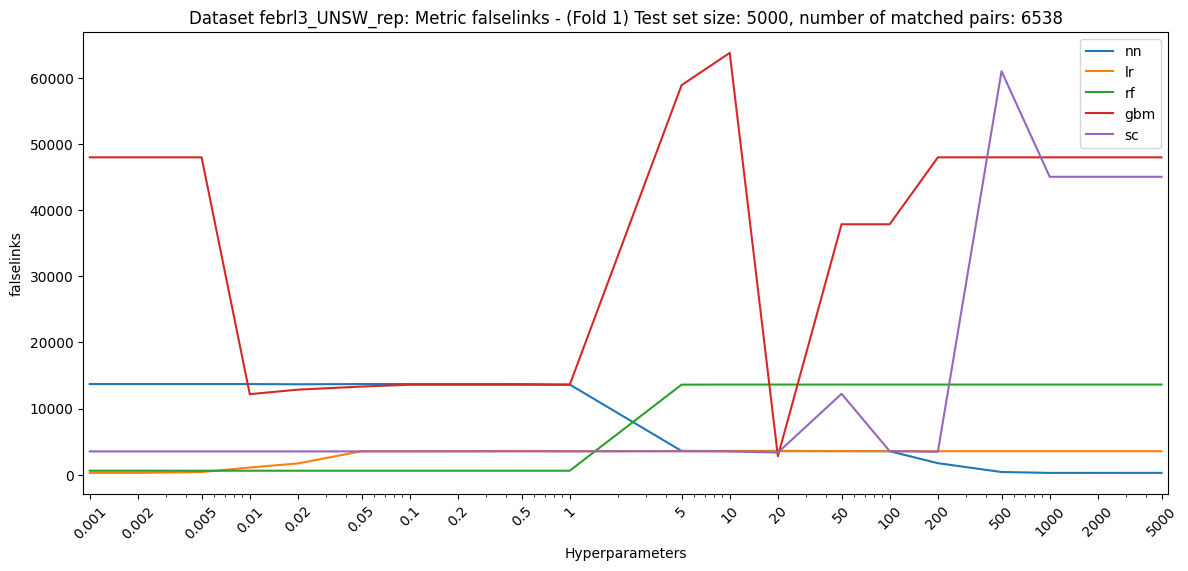

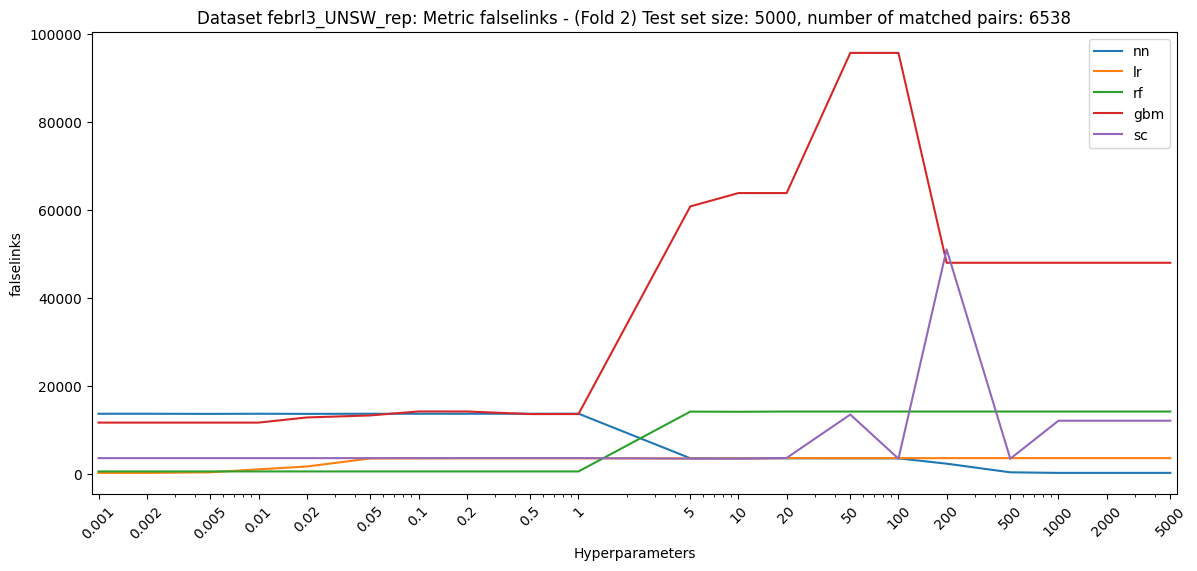

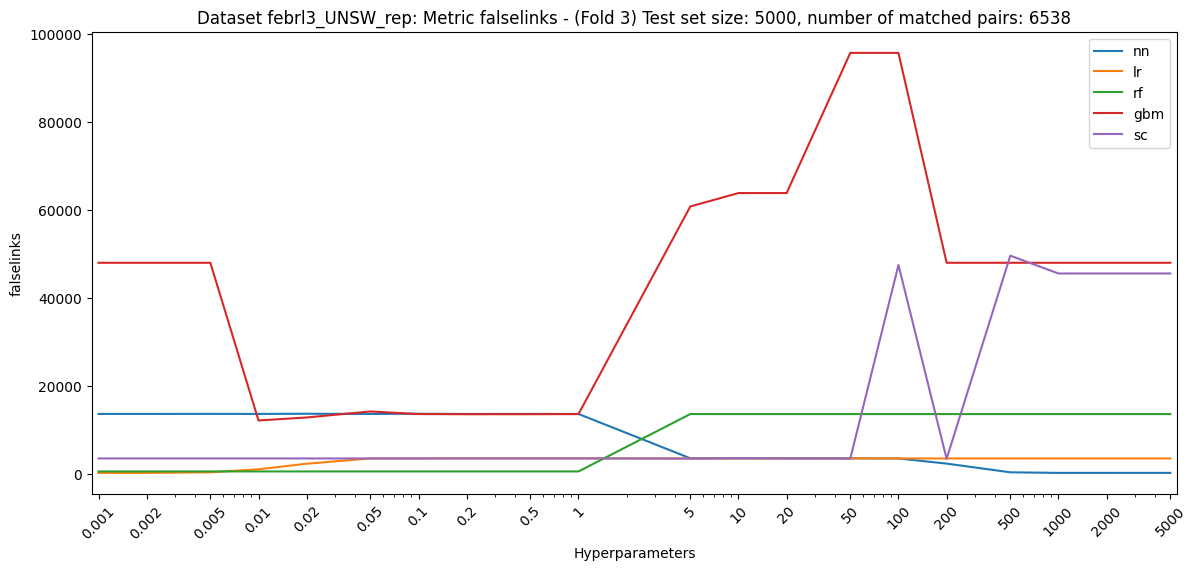

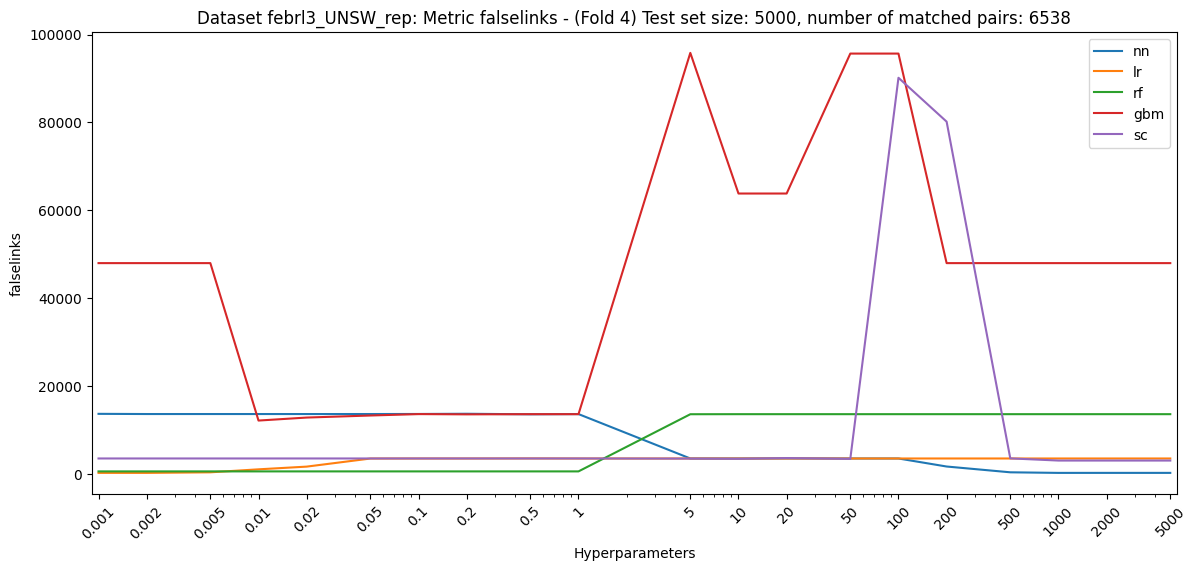

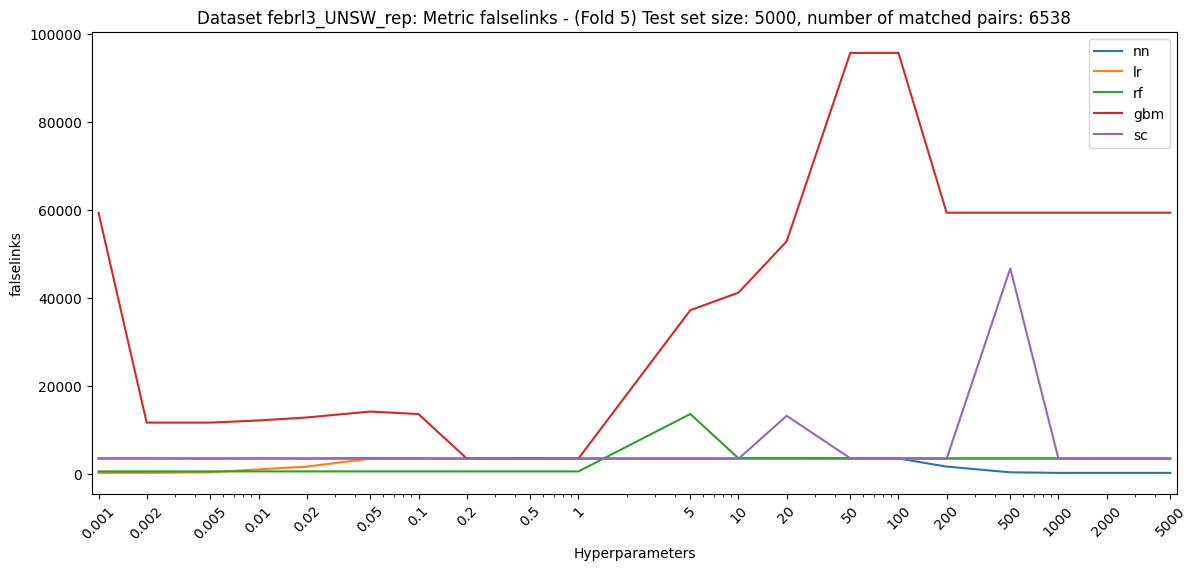

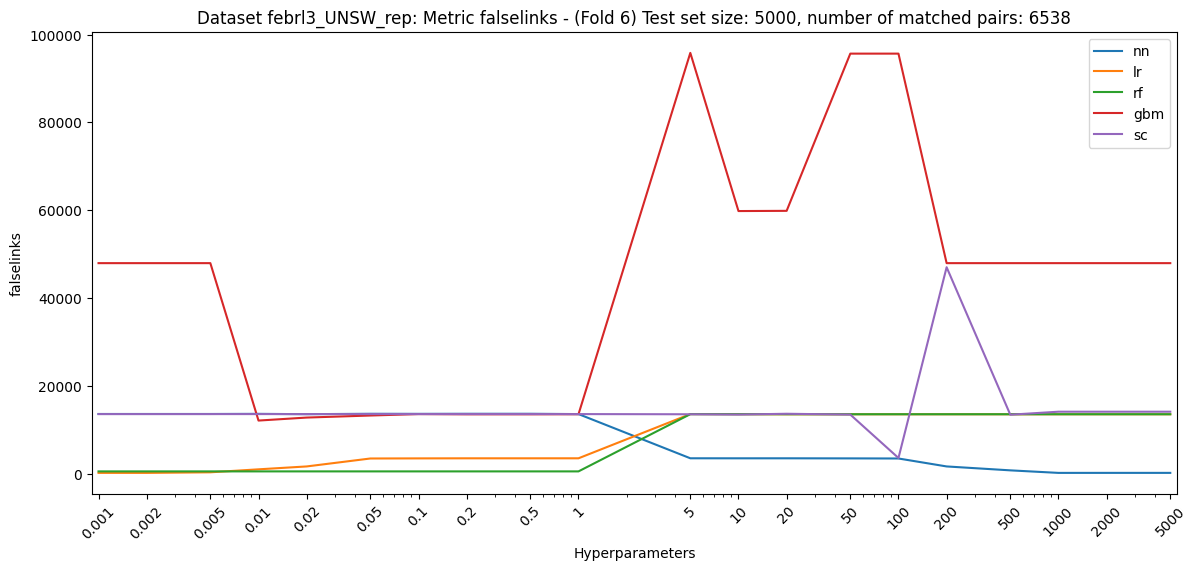

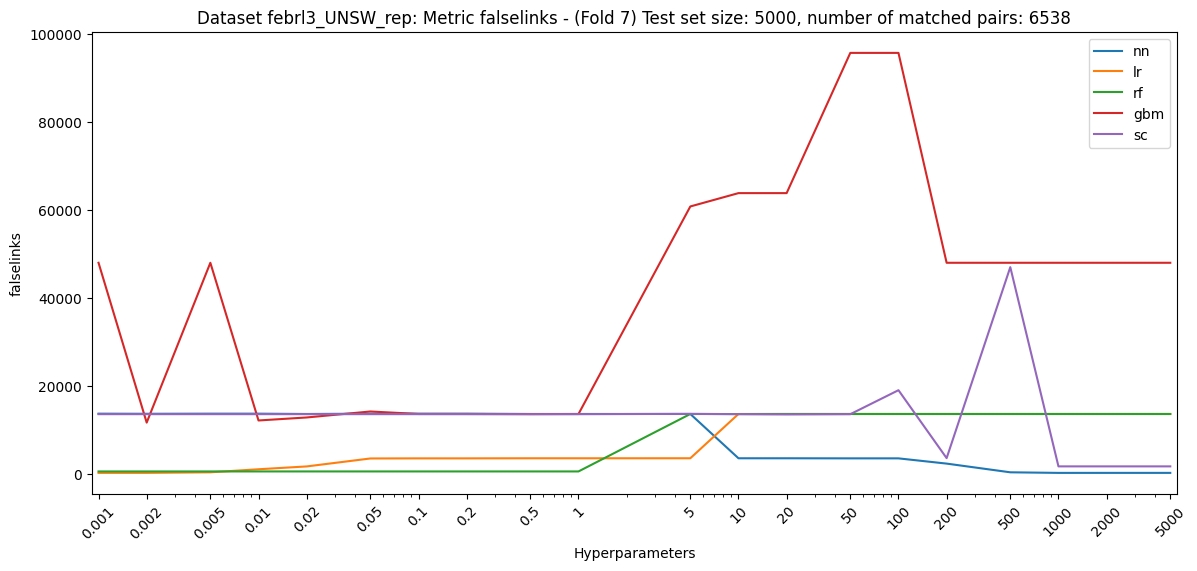

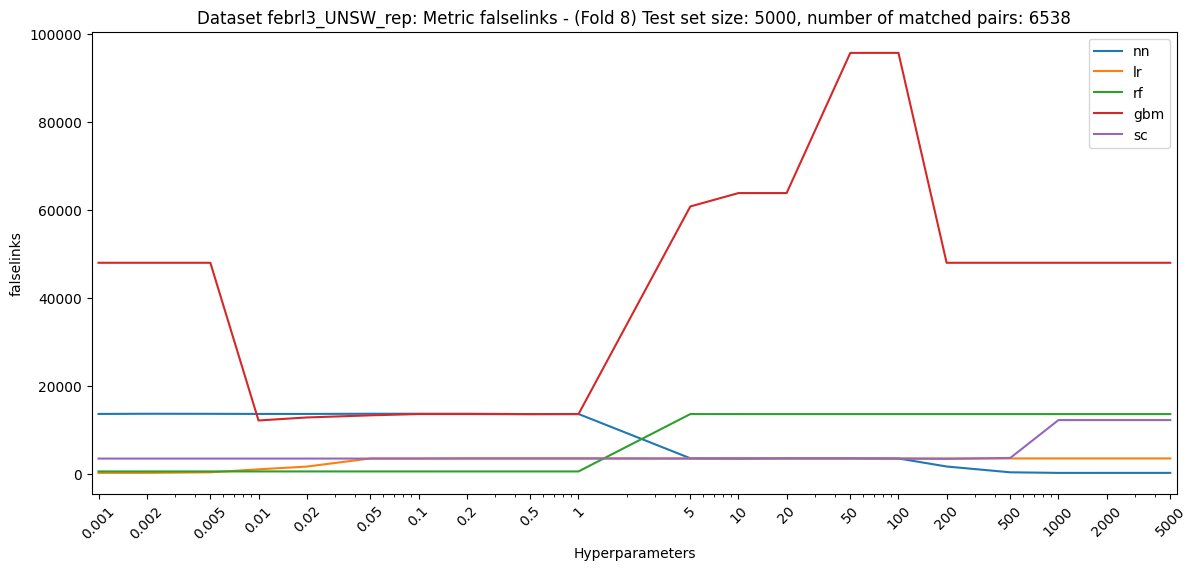

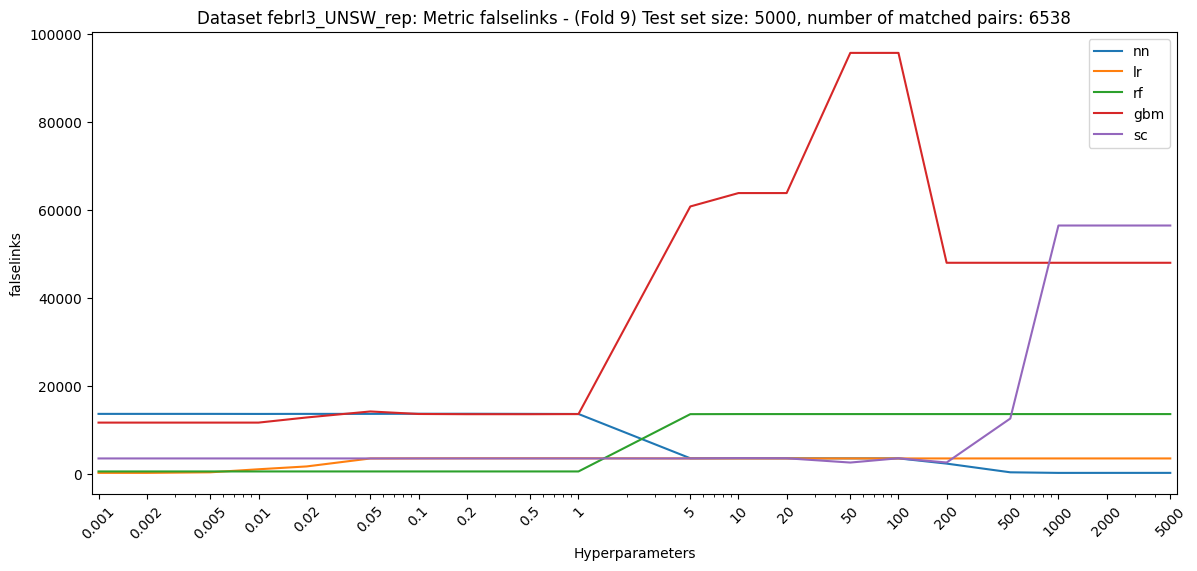

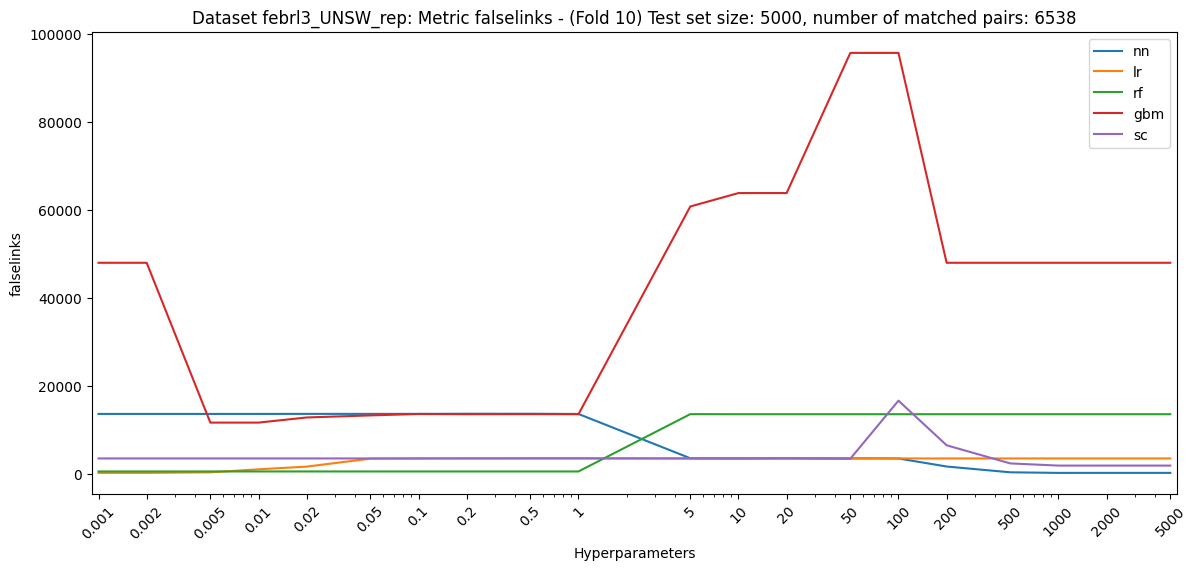

In [69]:
# fscore plots
for i in range(1,11):
    plots = []
    for currModel in modeltype:
        results = [x for x in fold if x["fold"] == i and x["model"] == currModel]
        plot = {
            'model': currModel,
            'result': []
        }
        for result in results:
            plot['result'].append(result['Fscore'])
        plots.append(plot)
    plot_result(filename, i, plots, number_of_records, number_of_duplicates, 'fscore', [0,0.1,0.2,0.3,0.4,0.5,.6,.7,.8,.9,1.0])  

# accuracy plots
for i in range(1,11):
    plots = []
    for currModel in modeltype:
        results = [x for x in fold if x["fold"] == i and x["model"] == currModel]
        plot = {
            'model': currModel,
            'result': []
        }
        for result in results:
            plot['result'].append(result['accuracyScore'])
        plots.append(plot)
    plot_result(filename, i, plots, number_of_records, number_of_duplicates, 'accuracy', [0,0.1,0.2,0.3,0.4,0.5,.6,.7,.8,.9,1.0])   

# accuracy plots
for i in range(1,11):
    plots = []
    for currModel in modeltype:
        results = [x for x in fold if x["fold"] == i and x["model"] == currModel]
        plot = {
            'model': currModel,
            'result': []
        }
        for result in results:
            plot['result'].append(result['noFalse'])
        plots.append(plot)
    plot_result(filename, i, plots, number_of_records, number_of_duplicates, 'falselinks', [])            

#save array into csv file 
np.savetxt(f"../test/result_{filename}.csv", fold,  
              delimiter = ",",
              fmt='%s')